**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 2: Shallow networks on CIFAR10

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
rng = np.random.default_rng()

In [2]:
Transform = ToTensor()

train_data = datasets.CIFAR10(
    root = "../data",
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = "../data", 
    train = False, 
    transform = Transform,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

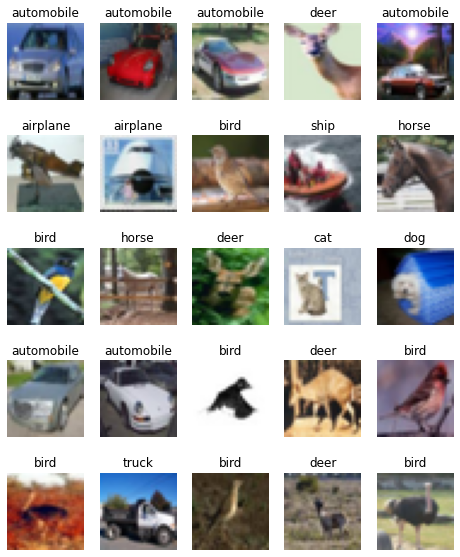

In [5]:
def show_imgs(X):
    figure = plt.figure(figsize=(8, 10))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        img, label = X[rng.integers(len(X))]
        figure.add_subplot(rows, cols, i)
        plt.title(X.classes[label])
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    
show_imgs(train_data)

In [6]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

n_classes = len(train_data.classes)
input_size = np.prod(train_data.data.shape[1:])

In [7]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, n_classes),
    nn.Softmax(dim=0))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.05)

In [8]:
summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 10]          30,730
           Softmax-3                   [-1, 10]               0
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [9]:
def train(epoch, model, data_loader, log_interval=200):
    
    model.train()
    
    total_train_loss = 0
    total_correct = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        pred = output.argmax(dim=1)
        
        total_correct += torch.sum(pred == target).item()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{:5}/{:5} ({:2.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

    accuracy_train = total_correct / len(data_loader.dataset)

    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [10]:
@torch.inference_mode()
def validate(model, data_loader):
   
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        output = model(data)
        val_loss += criterion(output, target).item()
        
        pred = output.argmax(dim=1)
        total_correct += torch.sum(pred == target).item()
        total_preds.append(pred.detach().cpu())
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print("Validation set: Average loss: {:.4f}, Accuracy: {:5}/{:5} ({:2.2f}%)\n".format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

In [11]:
%%time

epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.302682
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.300563


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2998, Accuracy:  2656/10000 (26.56%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 2.299684
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.300338


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2997, Accuracy:  2777/10000 (27.77%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 2.299460
Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.300161


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.3003, Accuracy:  2578/10000 (25.78%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 2.300252
Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.299984


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2985, Accuracy:  2536/10000 (25.36%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 2.299195
Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.300746


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2995, Accuracy:  2592/10000 (25.92%)

CPU times: user 1min 11s, sys: 104 ms, total: 1min 11s
Wall time: 22.2 s


## Loss and Accuracy evaluation during training

Let's now visualize how the training progressed.

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.
Accuracy is the classification accuracy for the test data.

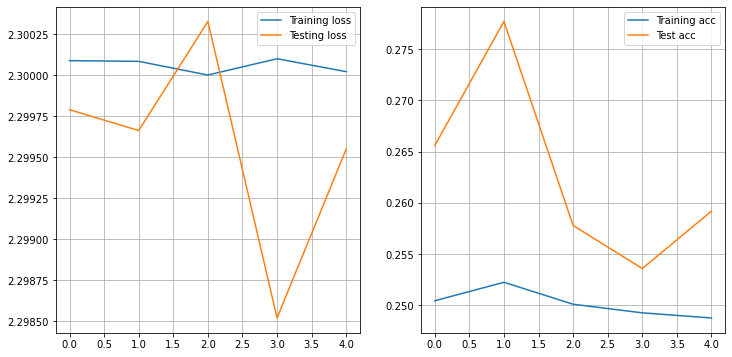

In [12]:
f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

In [13]:
confusion_matrix(val_result["predictions"], val_result["targets"])

array([[436, 102, 179, 141,  67, 120,  93, 120, 152, 122],
       [ 55, 145,  45,  27,  20,  16,  24,  26,  80,  86],
       [ 11,  19,  89,  58,  74,  61,  47,  62,   6,  20],
       [ 49,  63,  53, 122, 115, 116,  65, 117,  46,  28],
       [  3,   5,  35,   9,  37,  11,  25,  16,   1,   2],
       [ 33,  37,  82, 124,  83, 233,  76,  63,  67,  21],
       [ 83, 278, 313, 343, 424, 266, 524, 208,  69, 130],
       [ 19,  25,  62,  50,  65,  60,  63, 167,  15,  26],
       [234, 144, 104,  53,  70,  72,  26,  99, 471, 197],
       [ 77, 182,  38,  73,  45,  45,  57, 122,  93, 368]])

Weight of classification layer has size: torch.Size([10, 3072])


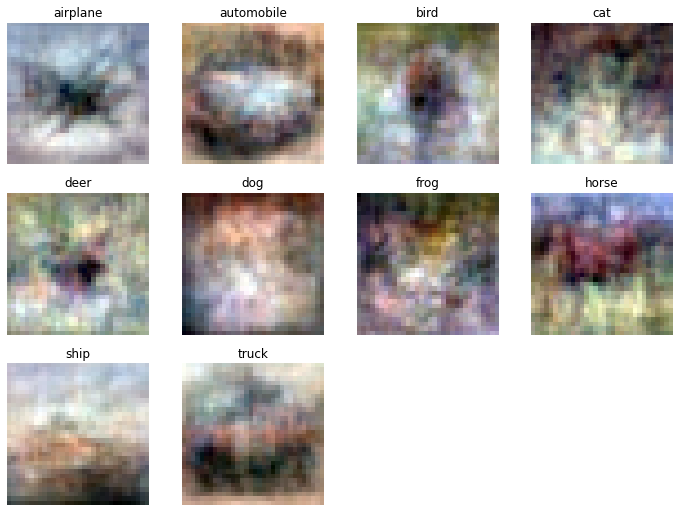

In [14]:
classifier_weight = dict(model.named_parameters())["1.weight"].detach().clone()

print(f"Weight of classification layer has size: {classifier_weight.size()}")

fig = plt.figure(figsize=(12,12))

cols = rows = int(ceil(sqrt(n_classes)))

for i, weight in enumerate(classifier_weight):
    ax = fig.add_subplot(rows, cols, 1+i)
    img = weight.reshape(train_data[0][0].shape).clone()
    for channel in img:
        channel -= channel.min()
        channel *= 255 / channel.max()
    ax.axis('off')
    plt.title(train_data.classes[i])
    ax.imshow(img.type(torch.int64).permute(1,2,0))